In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B, 32, 16, 16)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B, 64, 8, 8)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (B, 128, 4, 4)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [3]:
transform_plain = transforms.Compose([
    transforms.ToTensor()
])


In [4]:
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])


In [5]:
def get_loaders(transform_train, batch_size=128):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transforms.ToTensor())
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader


In [6]:
def train_model(model, trainloader, testloader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    accuracy_log = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.4f}")

        acc = test_accuracy(model, testloader, device)
        accuracy_log.append(acc)

    return accuracy_log
def test_accuracy(model, testloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return acc


In [7]:
def plot_accuracy(acc_plain, acc_aug):
    epochs = range(1, len(acc_plain)+1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc_plain, label='No Augmentation')
    plt.plot(epochs, acc_aug, label='With Augmentation')
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


Using device: cuda
Training without augmentation...
Epoch 1, Loss: 1.5934
Test Accuracy: 53.58%
Epoch 2, Loss: 1.1782
Test Accuracy: 61.74%
Epoch 3, Loss: 0.9976
Test Accuracy: 66.53%
Epoch 4, Loss: 0.8852
Test Accuracy: 67.84%
Epoch 5, Loss: 0.7875
Test Accuracy: 70.89%
Epoch 6, Loss: 0.7111
Test Accuracy: 70.63%
Epoch 7, Loss: 0.6360
Test Accuracy: 73.42%
Epoch 8, Loss: 0.5732
Test Accuracy: 73.39%
Epoch 9, Loss: 0.5081
Test Accuracy: 73.79%
Epoch 10, Loss: 0.4511
Test Accuracy: 73.39%

Training with data augmentation...
Epoch 1, Loss: 1.6951
Test Accuracy: 50.12%
Epoch 2, Loss: 1.3797
Test Accuracy: 55.37%
Epoch 3, Loss: 1.2189
Test Accuracy: 62.87%
Epoch 4, Loss: 1.0892
Test Accuracy: 64.66%
Epoch 5, Loss: 1.0038
Test Accuracy: 68.41%
Epoch 6, Loss: 0.9374
Test Accuracy: 68.68%
Epoch 7, Loss: 0.8815
Test Accuracy: 72.79%
Epoch 8, Loss: 0.8298
Test Accuracy: 73.66%
Epoch 9, Loss: 0.7945
Test Accuracy: 71.34%
Epoch 10, Loss: 0.7615
Test Accuracy: 75.52%


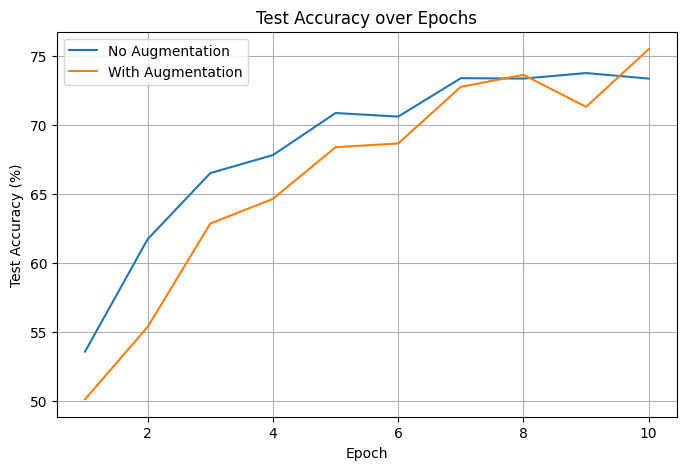

In [9]:
# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train model without augmentation
print("Training without augmentation...")
trainloader_plain, testloader = get_loaders(transform_plain)
model_plain = SimpleCNN()
acc_plain = train_model(model_plain, trainloader_plain, testloader, device)

# Train model with augmentation
print("\nTraining with data augmentation...")
trainloader_aug, _ = get_loaders(transform_augmented)
model_aug = SimpleCNN()
acc_aug = train_model(model_aug, trainloader_aug, testloader, device)

# Plot comparison
plot_accuracy(acc_plain, acc_aug)